In [1]:
# Import modules
import os
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm

In [2]:
def find_highest_metric(folder_path, metric):
    max_metric_value = 0.0
    best_file = None

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                metric_values = data[metric]
                max_metric_value_file = max(metric_values)
                if max_metric_value_file > max_metric_value:
                    max_metric_value = max_metric_value_file
                    best_file = file_path

    return best_file, max_metric_value

metrics_to_check = ["accuracy", "loss", "val_accuracy", "val_loss"]

# Replace 'models/training/history' with the actual path to your folder containing JSON files
folder_path = '../models/training/history'

for metric in metrics_to_check:
    best_file, max_metric_value = find_highest_metric(folder_path, metric)
    if best_file is not None:
        print(f"The file with the highest {metric} is: {best_file}")
        print(f"The highest {metric} is: {max_metric_value}")
    else:
        print(f"No JSON files found in the specified folder for {metric}.")

The file with the highest accuracy is: ../models/training/history/model_3_best_nodropout_adam_rgb_512_augment_history.json
The highest accuracy is: 0.9606190919876099
The file with the highest loss is: ../models/training/history/model_2_best_rmsprop_rgb_512_augment_history.json
The highest loss is: 1.7501258850097656
The file with the highest val_accuracy is: ../models/training/history/model_2_best_sgd_rgb_128_augment_history.json
The highest val_accuracy is: 0.5928241014480591
The file with the highest val_loss is: ../models/training/history/model_3_best_nodropout_sgd_rgb_32_augment_history.json
The highest val_loss is: 2497.628173828125


In [3]:
# Best peforming model based on validation accuracy is model_2_best_sgd_rgb_128_augment
best_model = '../models/training/history/model_2_best_sgd_rgb_128_augment_history.json'

In [4]:
# Specify how many best peforming models to show based on val_accuracy
n_best = 10
n_worst = 5

def rank_val_accuracy(folder_path):
    val_accuracy_ranking = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                val_accuracy = max(data["val_accuracy"])
                val_accuracy_ranking.append((file_path, val_accuracy))

    # Sort the ranking in descending order based on val_accuracy
    val_accuracy_ranking.sort(key=lambda x: x[1], reverse=True)

    return val_accuracy_ranking

val_accuracy_ranking = rank_val_accuracy(folder_path)

if val_accuracy_ranking:
    print(f"Ranking of files based on val_accuracy (showing n_best {n_best} out of {len(val_accuracy_ranking)}):")
    for rank, (file_path, val_accuracy) in enumerate(val_accuracy_ranking[:n_best], 1):
        print(f"{rank}. File: {file_path}, val_accuracy: {val_accuracy}")
    print("")
    print(f"Ranking of files based on val_accuracy (showing n_worst {n_worst} out of {len(val_accuracy_ranking)}):")
    for rank, (file_path, val_accuracy) in enumerate(val_accuracy_ranking[-n_worst:], 1):
        print(f"{rank}. File: {file_path}, val_accuracy: {val_accuracy}")
else:
    print("No JSON files found in the specified folder.")

Ranking of files based on val_accuracy (showing n_best 10 out of 96):
1. File: ../models/training/history/model_2_best_sgd_rgb_128_augment_history.json, val_accuracy: 0.5928241014480591
2. File: ../models/training/history/model_2_best_rmsprop_rgb_256_augment_history.json, val_accuracy: 0.59275883436203
3. File: ../models/training/history/model_2_best_rmsprop_rgb_128_augment_history.json, val_accuracy: 0.5925925970077515
4. File: ../models/training/history/model_2_best_adam_rgb_128_augment_history.json, val_accuracy: 0.5919560194015503
5. File: ../models/training/history/model_2_best_rmsprop_rgb_512_augment_history.json, val_accuracy: 0.5916785001754761
6. File: ../models/training/history/model_2_best_sgd_rgb_64_augment_history.json, val_accuracy: 0.5905212163925171
7. File: ../models/training/history/model_2_best_adam_rgb_256_augment_history.json, val_accuracy: 0.5899020433425903
8. File: ../models/training/history/model_2_best_sgd_rgb_256_augment_history.json, val_accuracy: 0.58926075

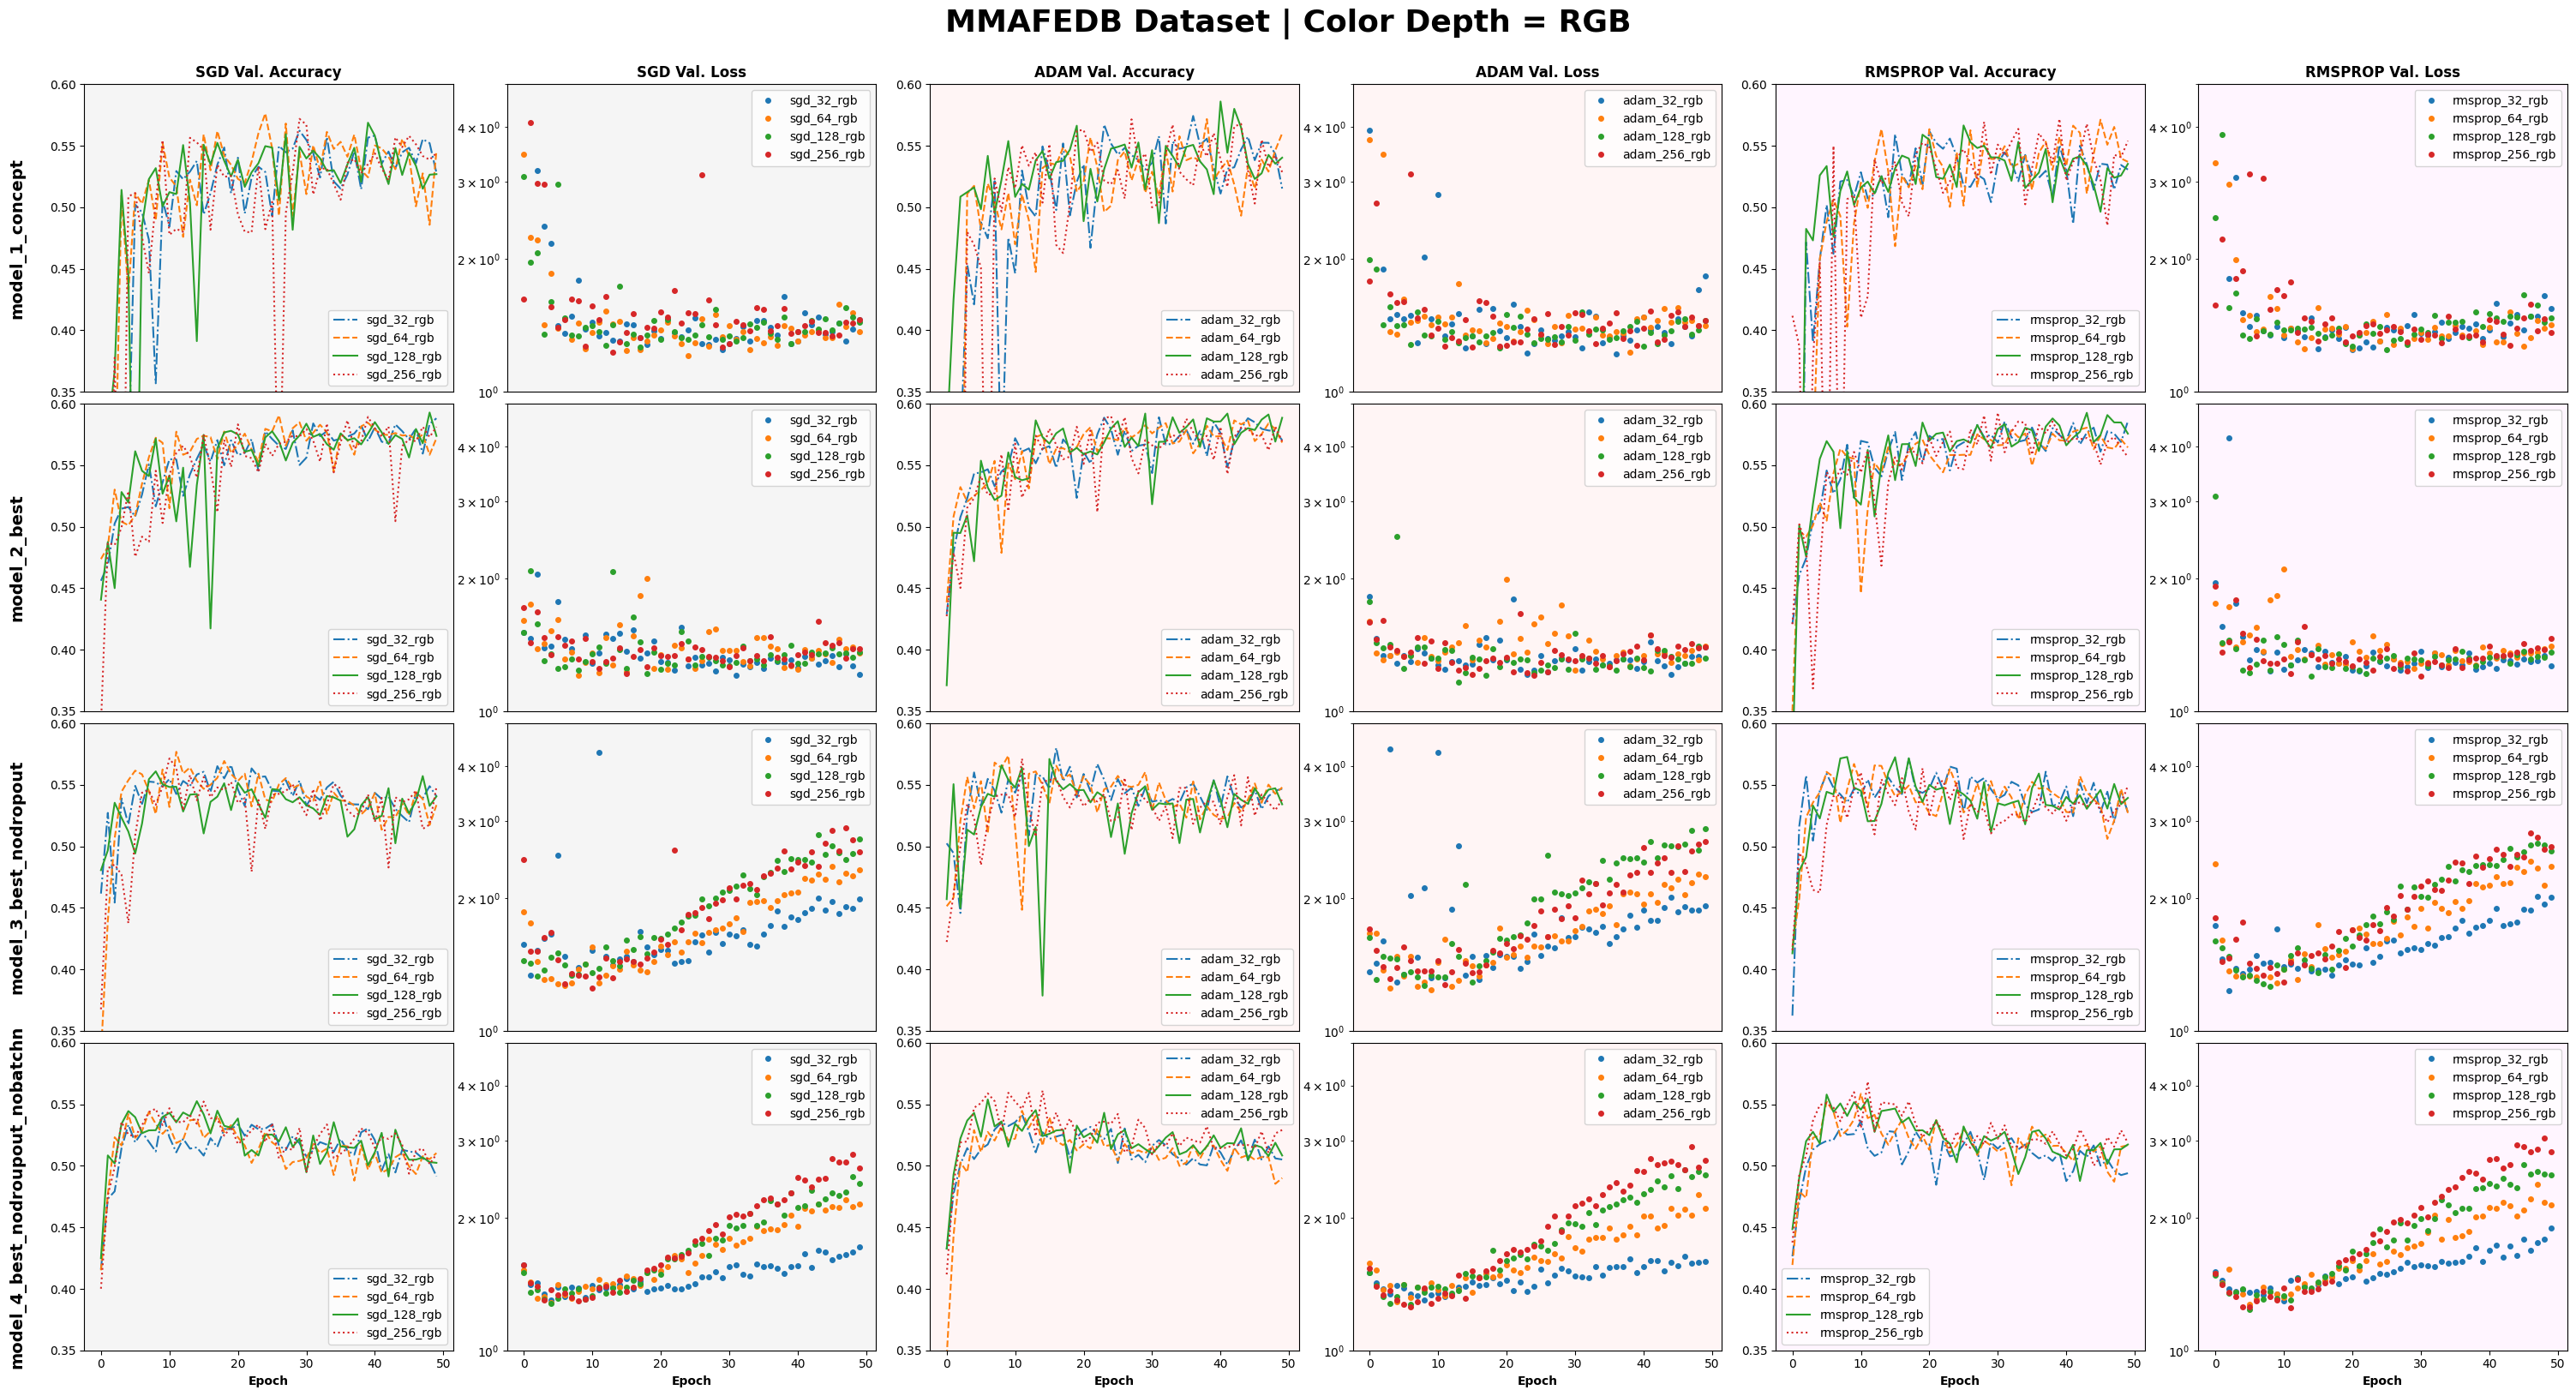

In [5]:
import os
import json
import re
import matplotlib.pyplot as plt

# Model regex pattern
regex_pattern = r'(model_\d+_[\w_]+)_(adam|rmsprop|sgd)_(rgb|grayscale)_(\d+)_augment_history\.json'

def plot_single_model(folder_path,save_file, optimizers=['sgd', 'adam', 'rmsprop'],batch_sizes=[32, 64, 128, 256],color_modes=['rgb']):
    # Create a figure with three subplots in a single row
    fig, axs = plt.subplots(len(models), 6, figsize=(30, 4 * len(models)))
    fig.suptitle(f'MMAFEDB Dataset | Color Depth = {color_modes[0].upper()}',weight='bold',fontsize=26, y=1.01)

    for model_num, model_name in enumerate(models):
        for i, optimizer in enumerate(optimizers):
            metrics = {}

            for filename in os.listdir(folder_path):
                if filename.endswith(".json"):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        match = re.match(regex_pattern, filename)
                        if match:
                            _model_name = match.group(1)
                            _optimizer = match.group(2)
                            _color_mode = match.group(3)
                            _batch_size = int(match.group(4))

                            if _model_name == model_name and _optimizer == optimizer \
                                    and _batch_size in batch_sizes and _color_mode in color_modes:
                                key = f'{_optimizer}_{_batch_size}_{_color_mode}'
                                metrics[key] = {'accuracy': data['val_accuracy'], 'loss': data['val_loss']}

            # Define a custom sorting function to sort by batch size and color mode
            def custom_sort(key):
                _, batch_size, color_mode = key.split('_')
                return (int(batch_size), color_mode)

            # Sort keys using the custom sorting function
            sorted_keys = sorted(metrics.keys(), key=custom_sort)

            # Define line styles for accuracy plots and use dots for loss plots
            line_styles = ['-.', '--', '-', ':']

            for j, key in enumerate(sorted_keys):
                history = metrics[key]
                axs[model_num, i * 2].plot(history['accuracy'], label=f'{key}', linestyle=line_styles[j % len(line_styles)])
                axs[model_num, i * 2].set_yscale('linear')
                axs[model_num, i * 2].legend()

                axs[model_num, i * 2 + 1].plot(history['loss'], label=f'{key}', linestyle=' ', marker='o', markersize=4)
                axs[model_num, i * 2 + 1].set_yscale('log')
                axs[model_num, i * 2 + 1].legend()
                axs[model_num, i * 2].set_ylim(0.35, 0.60)
                axs[model_num, i * 2 + 1].set_ylim(1, 5)
                
                if(model_num == 0):
                    axs[model_num, i * 2].set_title(f'{optimizer.upper()} Val. Accuracy',weight='bold')
                    axs[model_num, i * 2 + 1].set_title(f'{optimizer.upper()} Val. Loss',weight='bold')
                
                if(model_num == len(models)-1):
                    axs[model_num, i * 2].set_xlabel(f'Epoch',weight='bold')
                    axs[model_num, i * 2 + 1].set_xlabel(f'Epoch',weight='bold')
                    axs[model_num, i * 2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
                    axs[model_num, i * 2 + 1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
                else:
                    axs[model_num, i * 2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                    axs[model_num, i * 2 + 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

                axs[model_num, 0].set_ylabel(model_name, weight='bold', fontsize=14, labelpad=20)
                
    # Set common y-axis limits for accuracy and loss subplots
    for i in range(len(models)):
        axs[i, 0].set_ylim(0.35, 0.60)
        axs[i, 1].set_ylim(1, 5)

        axs[i, 0].patch.set_facecolor('#F5F5F5')  # Light Gray
        axs[i, 1].patch.set_facecolor('#F5F5F5')  # Light Gray

        axs[i, 2].patch.set_facecolor('#FFF5F5')  # Lighter Pink
        axs[i, 3].patch.set_facecolor('#FFF5F5')  # Lighter Pink

        axs[i, 4].patch.set_facecolor('#FFF5FF')  # Lighter Purple
        axs[i, 5].patch.set_facecolor('#FFF5FF')  # Lighter Purple
    
    # Adjust layout for better spacing
    plt.tight_layout(pad=0.5,h_pad=0.0,w_pad=0.3)
    plt.savefig(save_file, bbox_inches='tight', pad_inches=0.5)
    plt.show()

# Example usage for specific models
models = ['model_1_concept', 'model_2_best', 'model_3_best_nodropout', 'model_4_best_nodroupout_nobatchn']
plot_single_model(folder_path,save_file='../images/training_results_rgb.jpg')


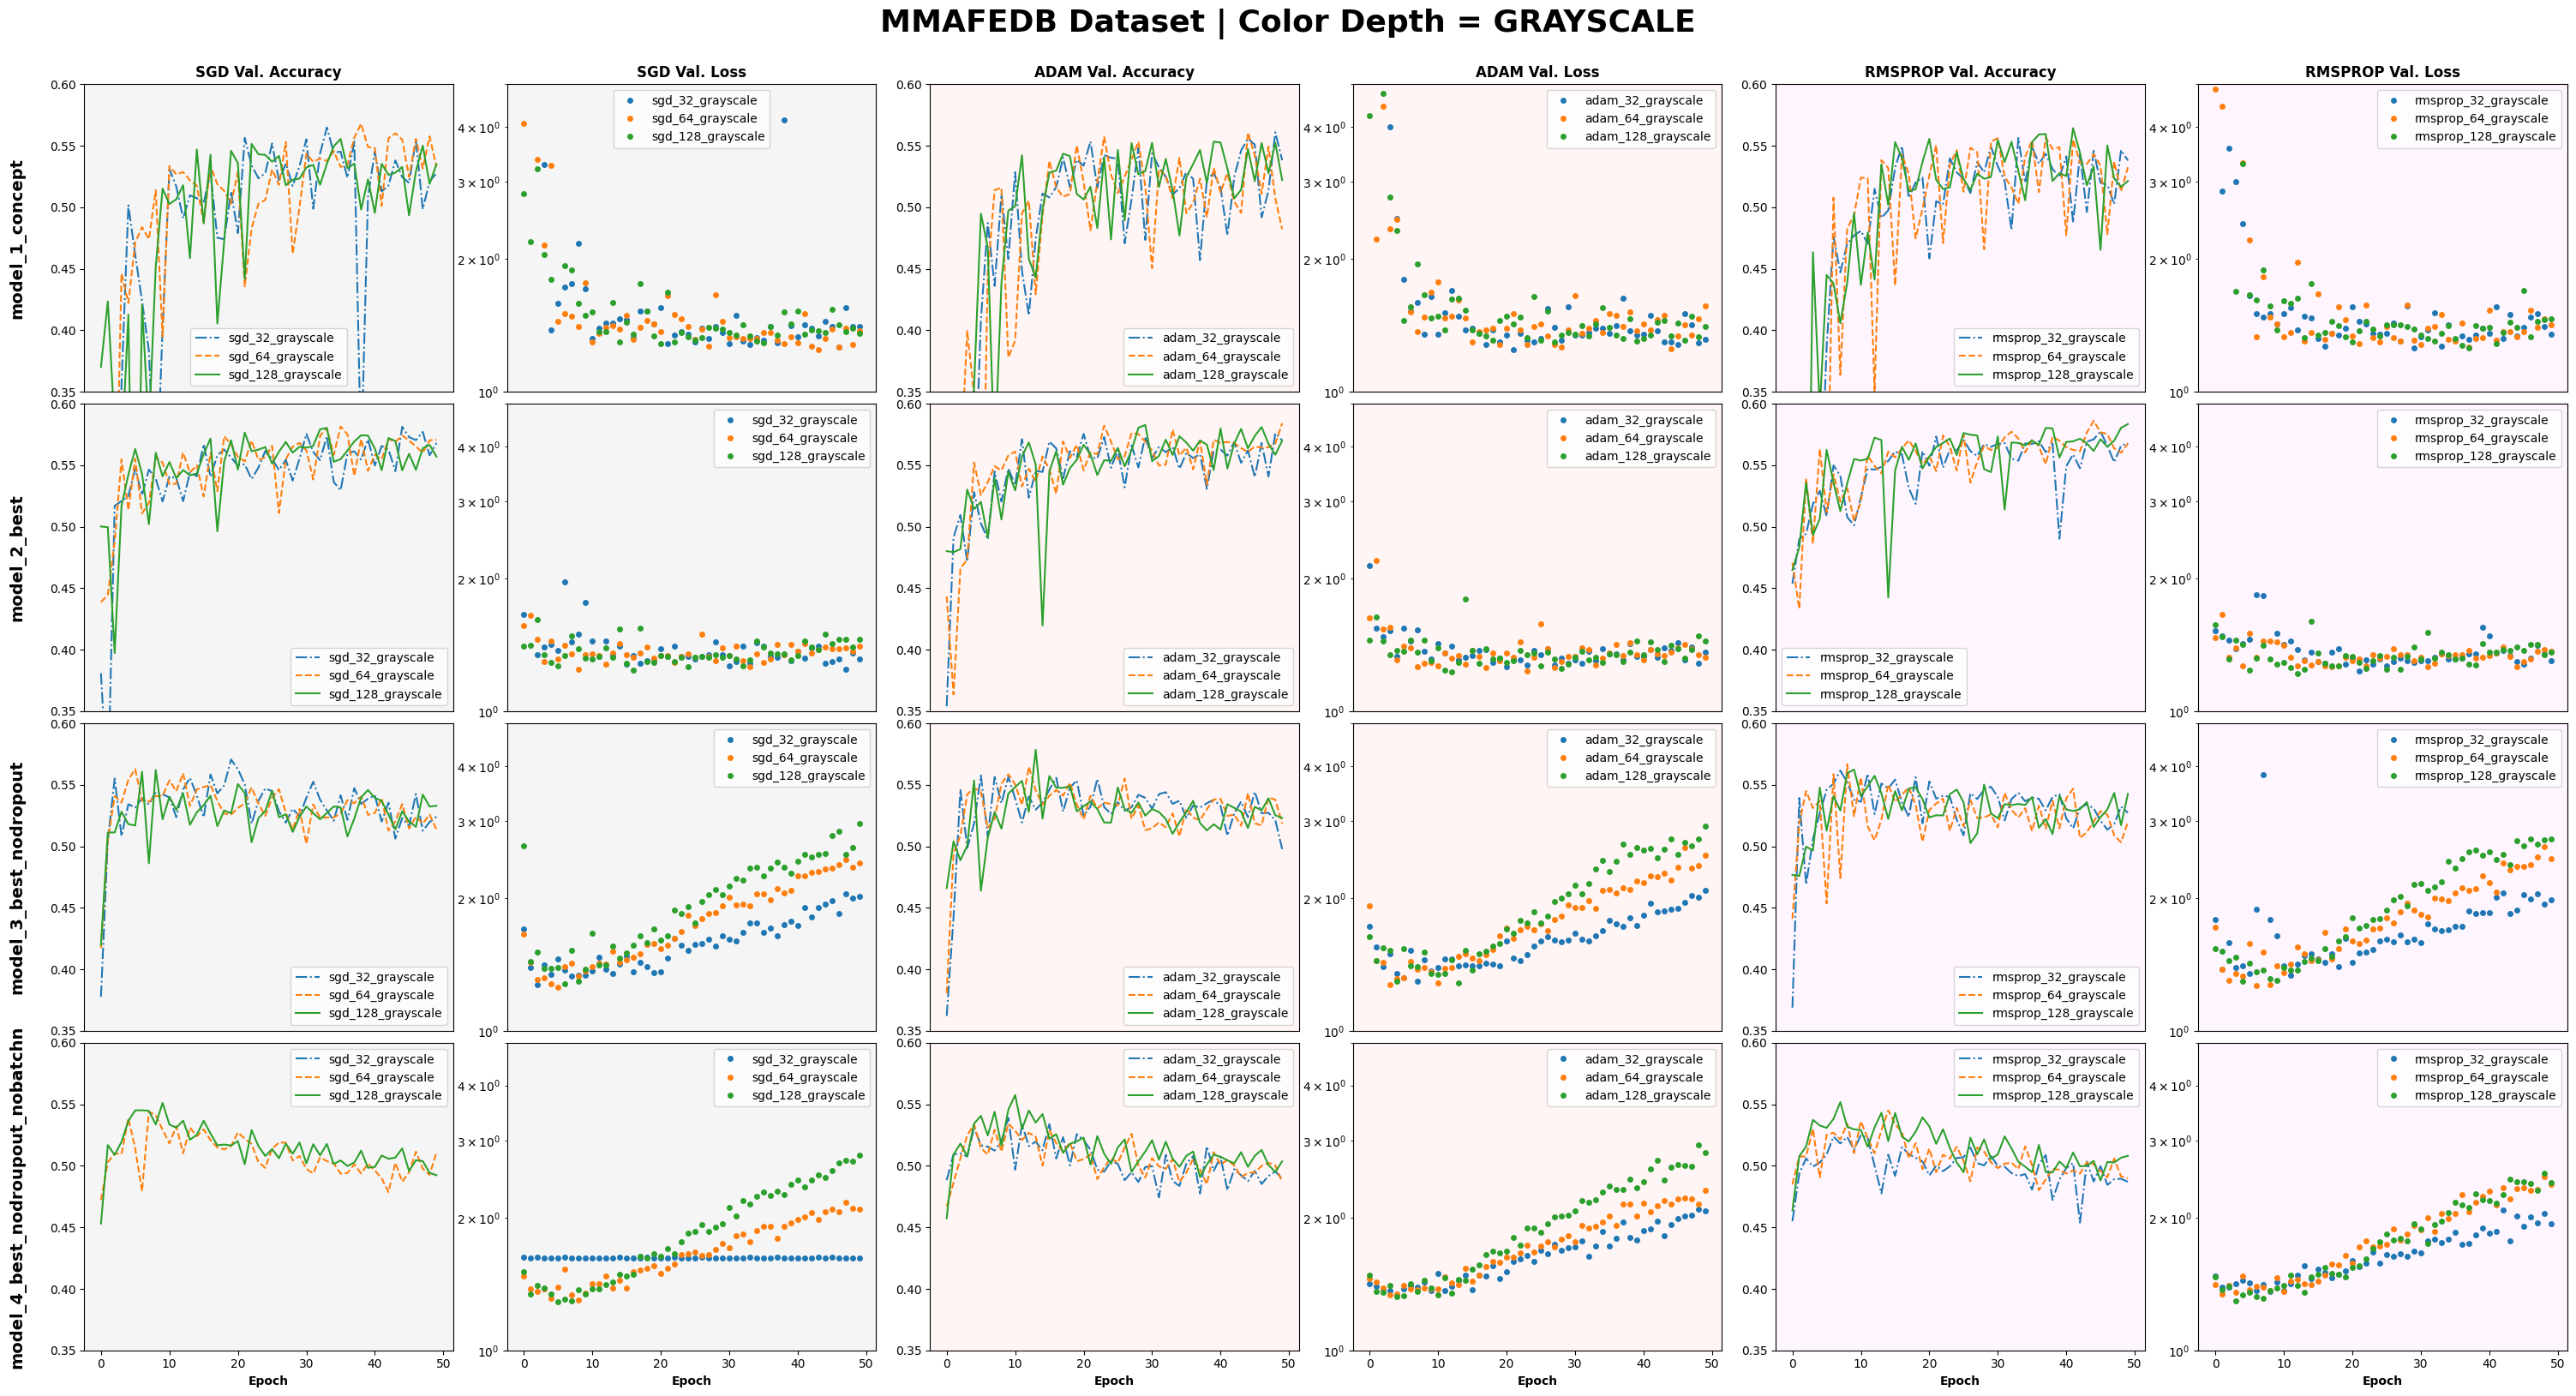

In [6]:
plot_single_model(folder_path,color_modes=['grayscale'],save_file='../images/training_results_grayscale.jpg')

In [7]:
# Creating a dataframe from the training data and calculating summary statistics

def create_df(folder_path):
    json_data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                fn = '_'.join(filename.split('_')[:-2])
                json_data[fn] = data

    return json_data

models = create_df(folder_path)

In [104]:
num_of_epoch = 50

# Using list comprehensions and zip for a more concise code
data = [(model, epoch + 1, metric) for model, metrics in models.items() for epoch in range(num_of_epoch) for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']]
m_index, epoch_index, metrics = zip(*data)

# Create the DataFrame directly
df = pd.DataFrame({'model': m_index, 'epoch': epoch_index, 'metric': metrics,
                   'value': [models[model][metric][epoch % num_of_epoch] for model, epoch, metric in data]})

# Pivot the DataFrame to get the desired structure
df = df.pivot_table(index=['model', 'epoch'], columns='metric', values='value')

# Reset index to make it look like the original structure
df.reset_index(inplace=True)

# Display the DataFrame
df



metric,model,epoch,accuracy,loss,val_accuracy,val_loss
0,model_1_concept_adam_grayscale_128,1,0.565931,1.230182,0.311111,6.025342
1,model_1_concept_adam_grayscale_128,2,0.586827,1.171501,0.097164,4.764573
2,model_1_concept_adam_grayscale_128,3,0.602047,1.134418,0.165856,2.770470
3,model_1_concept_adam_grayscale_128,4,0.611439,1.109672,0.353877,2.326337
4,model_1_concept_adam_grayscale_128,5,0.616265,1.090879,0.494734,1.453740
...,...,...,...,...,...,...
4795,model_4_best_nodroupout_nobatchn_sgd_rgb_64,46,0.841686,0.445349,0.493312,2.111477
4796,model_4_best_nodroupout_nobatchn_sgd_rgb_64,47,0.845098,0.433860,0.507841,2.202955
4797,model_4_best_nodroupout_nobatchn_sgd_rgb_64,48,0.845572,0.433287,0.505420,2.118610
4798,model_4_best_nodroupout_nobatchn_sgd_rgb_64,49,0.849038,0.423188,0.510378,2.149131


<AxesSubplot:xlabel='val_accuracy', ylabel='Count'>

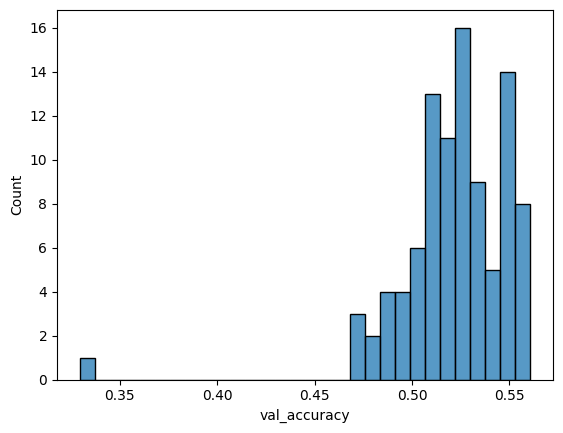

In [134]:
sns.histplot(df.groupby('model')['val_accuracy'].agg('mean'),bins=30)

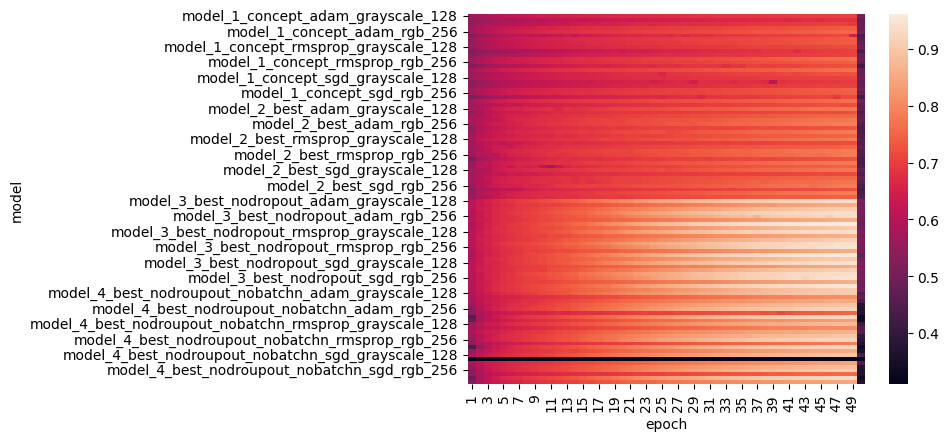

In [162]:
sns.heatmap(df.pivot_table(columns='epoch', index=['model'], values='accuracy', aggfunc='mean'))
plt.show()

In [258]:
df_max = df.groupby('model').agg('max').drop(columns='epoch')
df_min = df.groupby('model').agg('min').drop(columns='epoch')

In [259]:
print('Median of Max Values:',df_max.median())
print()
print('Mean of Max Values: ',df_max.mean())

Median of Max Values: metric
accuracy        0.784665
loss            1.491408
val_accuracy    0.567343
val_loss        2.738327
dtype: float64

Mean of Max Values:  metric
accuracy         0.810843
loss             1.529294
val_accuracy     0.565249
val_loss        47.865328
dtype: float64


In [271]:
max_accuracy = df_max['accuracy'].max()
max_val_accuracy = df_max['val_accuracy'].max()
min_val_loss = df_min['val_loss'].min()
min_loss = df_min['loss'].min()
print(f'The highest recorded accuracy from all models is: {max_accuracy}')
print(f'The highest recorded val_accuracy from all models is: {max_val_accuracy}')
print(f'The lowest recorded loss from all models is: {min_loss}')
print(f'The lowest recorded val_loss from all models is: {min_val_loss}')

The highest recorded accuracy from all models is: 0.9606190919876099
The highest recorded val_accuracy from all models is: 0.5928241014480591
The lowest recorded loss from all models is: 0.1184372678399086
The lowest recorded val_loss from all models is: 1.163872480392456


In [275]:
mean_accuracy = df_max['accuracy'].mean()
mean_val_accuracy = df_max['val_accuracy'].mean()
mean_loss = df_min['loss'].mean()
mean_val_loss = df_min['val_loss'].mean()
print(f'The mean of all max achieved accuracy is: {mean_accuracy}')
print(f'The mean of all max achieved val_accuracy is: {mean_val_accuracy}')
print(f'The mean of all min achieved loss is: {mean_loss}')
print(f'The mean of all min achieved val_loss is: {mean_val_loss}')

The mean of all max achieved accuracy is: 0.8108428701137503
The mean of all max achieved val_accuracy is: 0.5652485278745493
The mean of all min achieved loss is: 0.5292998483249297
The mean of all min achieved val_loss is: 1.2674342927833397


In [276]:
median_accuracy = df_max['accuracy'].median()
median_val_accuracy = df_max['val_accuracy'].median()
median_loss = df_min['loss'].median()
median_val_loss = df_min['val_loss'].median()
print(f'The median of all max achieved accuracy is: {median_accuracy}')
print(f'The median of all max achieved val_accuracy is: {median_val_accuracy}')
print(f'The median of all min achieved loss is: {median_loss}')
print(f'The median of all min achieved val_loss is: {median_val_loss}')

The median of all max achieved accuracy is: 0.7846645414829254
The median of all max achieved val_accuracy is: 0.5673431754112244
The median of all min achieved loss is: 0.6007280945777893
The median of all min achieved val_loss is: 1.2612722516059875


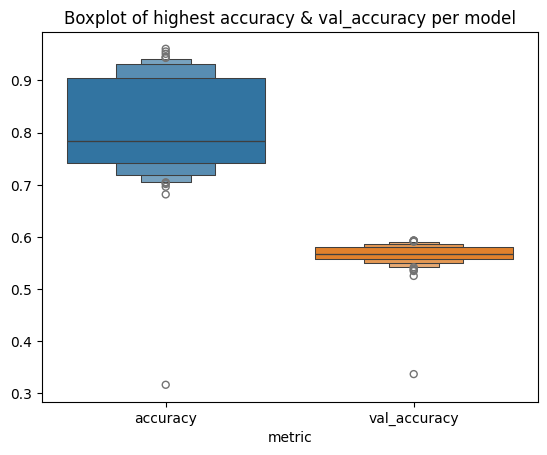

In [281]:
plt.title('Boxplot of highest accuracy & val_accuracy per model')
sns.boxenplot(df_max[['accuracy','val_accuracy']])
plt.show()

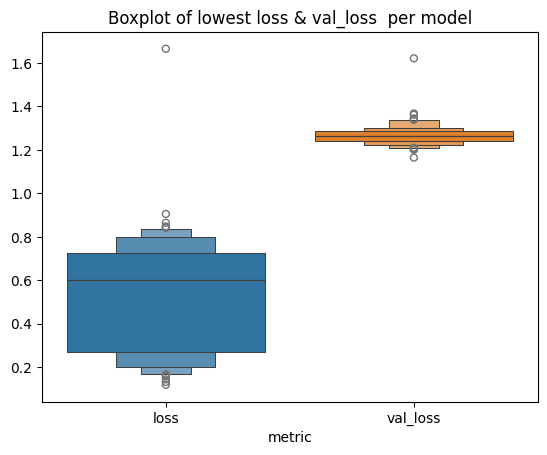

In [280]:
# Create a boxen plot with the filtered DataFrame
sns.boxenplot(data=df_min[['loss', 'val_loss']])
plt.title('Boxplot of lowest loss & val_loss  per model')
plt.show()